This notebook is identical to EfficientNetV2S_baseline with the only difference being that inside the pipeline we introduced AugMix which alternates with RandAugment and we increased the free layers of the network to allow it to learn more
we decided to use the same number of tuning end layers as EfficientNetV2S(std. augment) so 400. Having obtained the same performance online we avoided increasing the finetuning layers even more to avoid overfitting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import neptune
from datetime import date
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_cv as tfkv
from tensorflow import keras as tfk
from keras import applications
from tensorflow.keras.applications import MobileNetV2
from keras import layers as tfkl
from tensorflow.keras import mixed_precision
from io import StringIO
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

import keras_cv


load the data and split on train and validation we decided not to create a test set in order to have more data and thus decrease the variance.

In [7]:
data = np.load('Dataset/training_set_cleaned_NODUPLICATE.npz')
X = data['images']
y = data['labels']

# Assuming 'X' and 'y' are defined from the previous code
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1:])
print("Unique labels:", np.unique(y))

Shape of X: (11951, 96, 96, 3)
Shape of y: (11951, 1)
Number of samples: 11951
Number of features: (96, 96, 3)
Unique labels: [0 1 2 3 4 5 6 7]


In [ ]:

# Converting to one-hot encoding
seed = 90
y = tfk.utils.to_categorical(y,len(np.unique(y)))

# Split data into train_val and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=0.2, stratify=np.argmax(y,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (9560, 96, 96, 3), y_train shape: (9560, 8)
X_val shape: (2391, 96, 96, 3), y_val shape: (2391, 8)


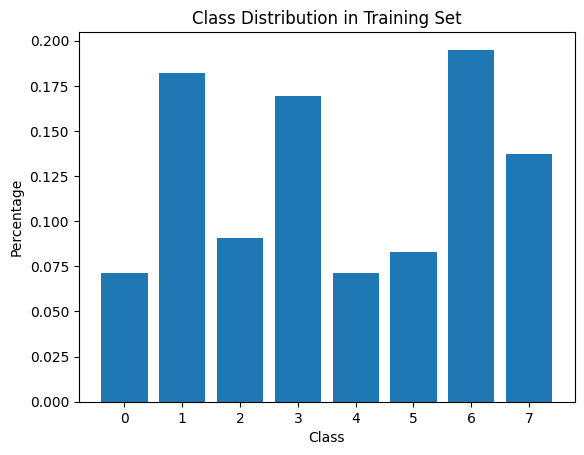

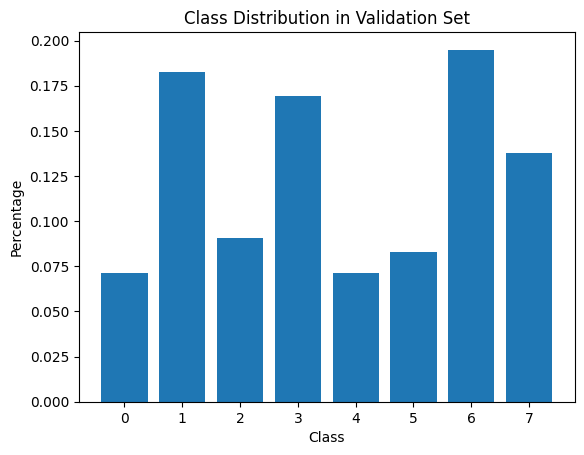

In [9]:

def plot_class_distribution(y, title):
  num_samples = np.zeros(8)
  tmp_y = np.argmax(y, axis=1)
  for i in range(8):
    num_samples[i] = np.sum(tmp_y == i)
  plt.bar(range(8), num_samples / np.sum(num_samples))
  plt.xlabel('Class')
  plt.ylabel('Percentage')
  plt.title(title)
  plt.show()

plot_class_distribution(y_train, 'Class Distribution in Training Set')
plot_class_distribution(y_val, 'Class Distribution in Validation Set')


# Parameters and Hyperparameters

In [10]:
data_params = {
    'batch_size': 32,
    'input_shape': (96, 96, 3),
    'num_classes': 8,
    'seed': 90
}

HYPERPARAMETERS = {
    "BATCH_SIZE": 32,
    "EPOCHS": 200,
    "LEARNING_RATE": 0.001,
    "LEARNING_DESCENT_PATIENCE": 5,
    "LEARNING_DESCENT_FACTOR": 0.5,
    "EARLY_STOPPING_PATIENCE": 10,
    "DROPOUT": 0.4,
    "LAYERS_FINE_TUNE": 400,
    "MODEL_NAME": "",
    "RAND_AUGMENT_MAGNITUDE": 0.5,
    "RAND_AUGMENT_AUGMENTATIONS_PER_IMAGE": 2
}

# Build the model

## Augmentations

In [11]:
AUTO = tf.data.AUTOTUNE

augmix = keras_cv.layers.AugMix(
    value_range=(0, 255),
    severity=0.5,
    num_chains=3,
    chain_depth=[1, 3],
    alpha=1.0,
)

grid_mask = keras_cv.layers.GridMask(
      ratio_factor=(0, 0.5), rotation_factor=0.15, fill_mode="constant", fill_value=0.0)

cutout_constant = keras_cv.layers.RandomCutout(height_factor = 0.5, width_factor = 0.5, fill_mode="constant")

randomZoom = keras_cv.layers.RandomZoom(height_factor=0.5, width_factor=0.5)

hue = keras_cv.layers.RandomHue(factor=0.3, value_range=(0, 255))

channelShuffle = keras_cv.layers.ChannelShuffle(groups=3)

channelShift = keras_cv.layers.RandomChannelShift(value_range=(0, 255),factor=0.3)

simple_aug = tfk.Sequential(
    [
        tfkl.RandomFlip("horizontal_and_vertical"),
        tfkl.RandomRotation(factor=0.3, fill_mode = "nearest"),
        tfkl.RandomZoom(height_factor=0.1, width_factor=0.1, fill_mode = "nearest"),
    ]
)


rand_augment = tfkv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=HYPERPARAMETERS['RAND_AUGMENT_AUGMENTATIONS_PER_IMAGE'],
    magnitude=HYPERPARAMETERS['RAND_AUGMENT_MAGNITUDE'],
    geometric = True
)

grid_mask_or_rand_cutout = [
    cutout_constant,
    grid_mask
]

color_trasformations = [
     hue,
     channelShuffle,
     channelShift
]

randAug_or_AugMix = [
     rand_augment,
     augmix
]


def augment(images):
  image = tf.cast(images, tf.uint8)
  images = simple_aug(image)
  images = keras_cv.layers.RandomChoice(layers=randAug_or_AugMix)(images)
  images = keras_cv.layers.RandomChoice(layers=grid_mask_or_rand_cutout)(images)
  images = keras_cv.layers.RandomChoice(layers=color_trasformations)(images)

  return images


## Data loaders

In [12]:

train_data = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(HYPERPARAMETERS['EPOCHS'] * 100)
    .batch(HYPERPARAMETERS['BATCH_SIZE'])
    .map(
        lambda x, y: (augment(x), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

val_data = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(HYPERPARAMETERS['BATCH_SIZE'])
    .map(
        lambda x, y: (augment(x), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)


### Plotting to see the augmentations

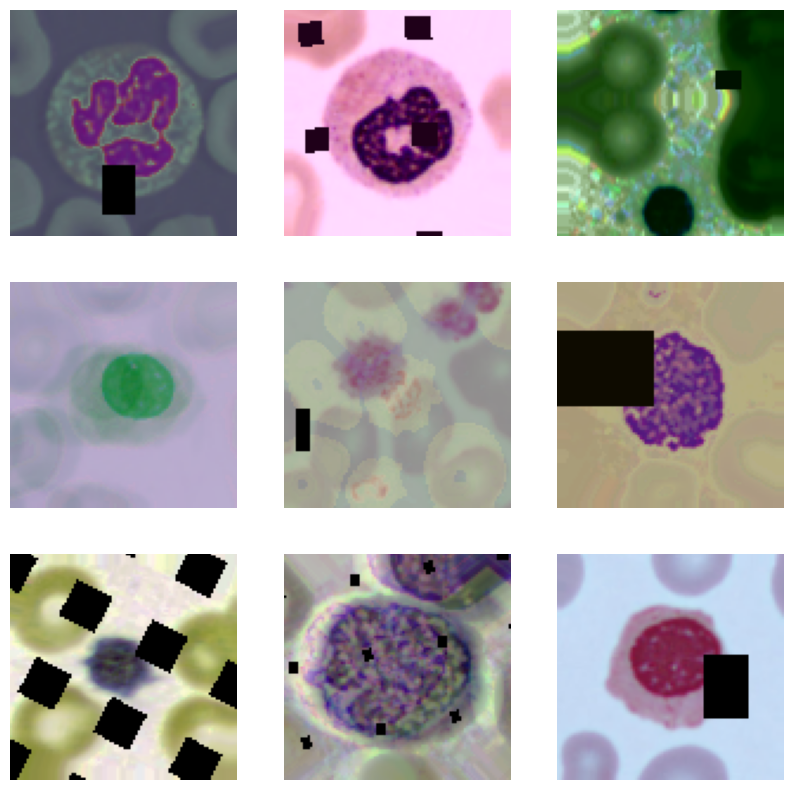

In [13]:
sample_images, _ = next(iter(train_data))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.axis("off")


## Model Definition

In [14]:
print('Loading model with ImageNet weights...')
MODEL_IMPORTED =tfk.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=data_params['input_shape'],
    pooling="avg",
    classes=8,
    classifier_activation="softmax",
    include_preprocessing=True,
    name="efficientnetv2-s",
)

# Set all layers in the convolutional base to Trainable (will FREEZE initial layers further below).
MODEL_IMPORTED.trainable = True

# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = HYPERPARAMETERS['LAYERS_FINE_TUNE']
num_layers = len(MODEL_IMPORTED.layers)

print("Num_layers fine tune " + str(num_layers_fine_tune))
print("Num_layers: " + str(num_layers))

# Freeze the initial layers in the convolutional base.
for model_layer in MODEL_IMPORTED.layers[:num_layers - num_layers_fine_tune]:
    model_layer.trainable = False

print(f"\nConfigured to fine tune the last", num_layers_fine_tune, "convolutional layers...\n")

Loading model with ImageNet weights...
Num_layers fine tune 400
Num_layers: 514

Configured to fine tune the last 400 convolutional layers...



In [ ]:
def build_model():
  """Builds the Keras model.
  """
  inputs = tf.keras.Input(shape=data_params['input_shape'])

  x = MODEL_IMPORTED(inputs)

  x = tfkl.Dense(128, activation='relu')(x)
  x = tfkl.Dropout(HYPERPARAMETERS['DROPOUT'])(x)
  x = tfkl.Dense(64, activation='relu')(x)
  x = tfkl.Dropout(HYPERPARAMETERS['DROPOUT'])(x)


  outputs = tfkl.Dense(data_params['num_classes'], activation='softmax')(x)

  model = tfk.Model(inputs=inputs, outputs=outputs)
  print(model.summary())

  return model

In [16]:
model = build_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,504,104 (78.22 MB)

 Trainable params: 18,970,352 (72.37 MB)

 Non-trainable params: 1,533,752 (5.85 MB)

None


In [ ]:
model.compile(
    
    optimizer=tf.keras.optimizers.AdamW(learning_rate=HYPERPARAMETERS["LEARNING_RATE"]),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

Configuration of Neptune

In [ ]:
# prompt: class neptune callback

run = neptune.init_run(
    project=f"lp1807/Homework1" , # Replace with your Neptune project
    api_token="API_TOKEN",
    name="EfficientNetV2S-AUGMIX"
)

# Create a NeptuneCallback
class NeptuneCallback(tfk.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        run["model/train/accuracy"].log(logs["accuracy"])
        run["model/train/loss"].log(logs["loss"])
        run["model/val/accuracy"].log(logs["val_accuracy"])
        run["model/val/loss"].log(logs["val_loss"])


def saveNeptune_Drive():

  # Log the entire history dictionary to Neptune
  run["training/history"] = history.history  # <-- This line logs the entire training history

  for epoch in range(len(history.history['accuracy'])):
    run["training/epoch/train_accuracy"].log(history.history['accuracy'][epoch])
    run["training/epoch/val_accuracy"].log(history.history['val_accuracy'][epoch])
    run["training/epoch/train_loss"].log(history.history['loss'][epoch])
    run["training/epoch/val_loss"].log(history.history['val_loss'][epoch])

  model_summary = StringIO()
  model.summary(print_fn=lambda x: model_summary.write(x + "\n"))
  run["model/summary"] = model_summary.getvalue()

  # Log model weights and configuration
  run["model/weights"] = neptune.types.File.as_pickle(model.get_weights())
  run["model/config"] = model.get_config()

  model_file_path = f"400ftAugMixMagli5.keras"
  model.save(model_file_path)

  # Log the .keras model file to Neptune
  run["model/file"].upload(model_file_path)

  # Convert history to DataFrame and save as CSV
  history_df = pd.DataFrame(history.history)
  history_file_path = f"400ftAugMixMagli5.csv"
  history_df.to_csv(history_file_path, index=False)

  # Log the CSV file to Neptune
  run["training/history_file"].upload(history_file_path)
  run["notebook"].upload("/content/drive/MyDrive/Colab Notebooks/the_boss.ipynb")

def saveHyperparameters():
    # Saving as Json
    run["hyperparameters"] = HYPERPARAMETERS

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/lp1807/Homework1/e/HOM-300


In [19]:
# Define the checkpoint directory on Google Drive or locally
checkpoint_dir = '/checkpoints/'  # Modify this path as needed
os.makedirs(checkpoint_dir, exist_ok=True)
saveHyperparameters()

neptune_cbk = NeptuneCallback()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"400ftAugMixMagli5Backup.keras",
    save_weights_only=False,  # Save only model weights, not the entire model
    monitor='val_loss',      # Monitor validation loss for checkpointing
    save_best_only=True,     # Save model at the end of each epoch regardless of improvement
    save_freq = "epoch",                 # Save checkpoint every 5 epochs
    verbose=1                 # Print message when saving a checkpoint
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=HYPERPARAMETERS["EARLY_STOPPING_PATIENCE"],  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# ReduceLROnPlateau callback to decrease the learning rate when the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=HYPERPARAMETERS["LEARNING_DESCENT_FACTOR"],  # Reduce the learning rate by a factor of 0.5
    patience=HYPERPARAMETERS["LEARNING_DESCENT_PATIENCE"],  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,  # Lower bound on the learning rate
    verbose=1  # Print out a message when learning rate is reduced
)

# Train the model with the callbacks
history = model.fit(
    train_data,
    epochs=HYPERPARAMETERS["EPOCHS"],
    validation_data=val_data,
    callbacks=[ early_stopping, reduce_lr, checkpoint_callback]  # Include both the callbacks here
)

saveNeptune_Drive()

# Finalize the Neptune run
run.stop()

Epoch 1/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.4786 - loss: 1.4737
Epoch 1: val_loss improved from inf to 0.60514, saving model to 400ftAugMixMagli5Backup.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 293s 789ms/step - accuracy: 0.4791 - loss: 1.4726 - val_accuracy: 0.8030 - val_loss: 0.6051 - learning_rate: 0.0010
Epoch 2/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.7673 - loss: 0.7321
Epoch 2: val_loss improved from 0.60514 to 0.47972, saving model to 400ftAugMixMagli5Backup.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 224s 744ms/step - accuracy: 0.7674 - loss: 0.7319 - val_accuracy: 0.8436 - val_loss: 0.4797 - learning_rate: 0.0010
Epoch 3/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.8147 - loss: 0.5840
Epoch 3: val_loss improved from 0.47972 to 0.42045, saving model to 400ftAugMixMagli5Backup.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 216s 716ms/step - accuracy: 0.8147 - loss: 0.5840 - val_accuracy: 0.8637 - val_loss: 0.4205 - learning_rate: 0.0010
Epoch 4/

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 251 operations to synchronize with Neptune. Do not kill this process.
[neptune] [error  ] Error occurred during asynchronous operation processing: Cannot upload file c:\content\drive\MyDrive\Colab Notebooks\the_boss.ipynb: Path not found or is a not a file.
[neptune] [info   ] All 251 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/lp1807/Homework1/e/HOM-300/metadata


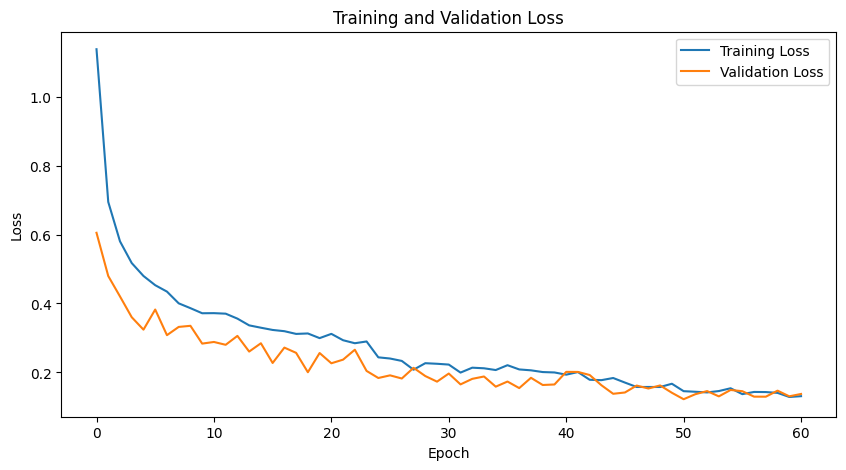

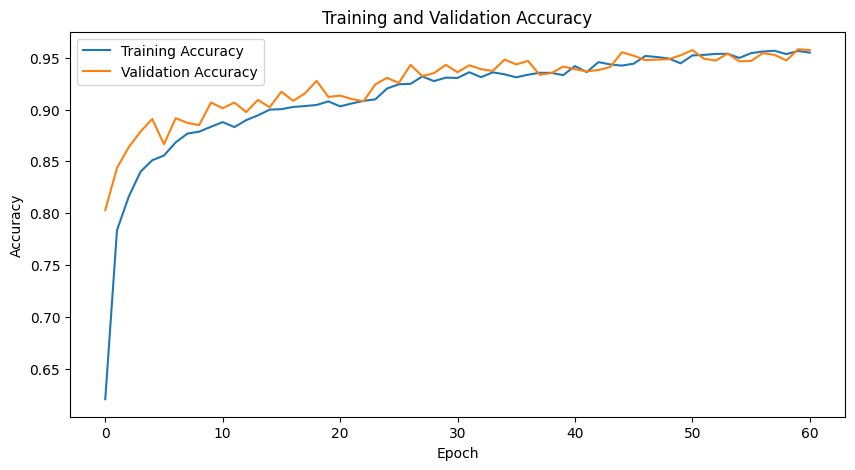

In [20]:
# prompt: plot loss and accuracy on training and validation through tranining

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()